In [1]:
import numpy as np
import pandas as pd
from pandas.io import sql
from sqlalchemy import create_engine
import os
import matplotlib.pyplot as plt
import matplotlib.ticker as tick
from matplotlib import rcParams
from pylab import rcParams
import seaborn as sns

In [2]:
sns.set()
rcParams['font.sans-serif'] = ['Inconsolata']
rcParams["legend.borderpad"] = .5
rcParams['figure.figsize'] = 16, 10
SMALL_SIZE = 8
MEDIUM_SMALL_SIZE = 10
MEDIUM_SIZE = 12
MEDIUM_LARGE_SIZE = 14
BIGGER_SIZE = 16
plt.rc('font', size=SMALL_SIZE)
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_LARGE_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [3]:
%load_ext dotenv
%dotenv ../.env

In [4]:
cnx = create_engine(os.getenv('EDMDB'))

#### Part 1: Regular Lots

How many regular lots are there?

In [5]:
regular_lot_count = pd.read_sql_query('''SELECT COUNT(*)
FROM dcp.mappluto_unclipped
WHERE "IrrLotCode" = 'N';''', cnx)
regular_lot_count

,count
0,722042


Of the regular lots, how many have lot areas equal to the lot front times the lot depth, and how many don't?

In [6]:
regular_lotarea = pd.read_sql_query('''WITH regular_lotarea AS (
SELECT "BBL",
CASE
    WHEN "LotArea" = ROUND("LotFront" * "LotDepth") THEN 'Y'
    ELSE 'N'
END AS regular_lotarea_ind
FROM dcp.mappluto_unclipped
WHERE "IrrLotCode" = 'N'
)
SELECT regular_lotarea_ind, COUNT(*)
FROM regular_lotarea
GROUP BY regular_lotarea_ind;''', cnx)
regular_lotarea

,regular_lotarea_ind,count
0,N,63747
1,Y,658295


For the lots with illogical lot areas, how many of them are equal to the rounded ESRI shape area?

In [7]:
lotarea_eq_shape = pd.read_sql_query('''SELECT COUNT(*)
FROM dcp.mappluto_unclipped
WHERE "IrrLotCode" = 'N'
AND "LotArea" <> ROUND("LotFront" * "LotDepth")
AND "LotArea" = ROUND("Shape_Area");''', cnx)
lotarea_eq_shape

,count
0,1591


Break out the areas by borough

In [8]:
boro_reg_breakout = pd.read_sql_query('''SELECT "Borough",
SUM("LotArea") AS "LotArea",
SUM(ROUND("LotFront" * "LotDepth")) AS "FrontxDepth",
SUM(ROUND("Shape_Area")) AS "ShapeArea",
SUM(ROUND(("LotFront" * "LotDepth")) - "LotArea") AS Diff_LotArea_FxD,
SUM(ROUND("Shape_Area") - "LotArea") AS Diff_LotArea_SA
FROM dcp.mappluto_unclipped p
WHERE "IrrLotCode" = 'N'
AND "LotArea" <> ROUND("LotFront" * "LotDepth")
AND "LotArea" <> ROUND("Shape_Area")
GROUP BY "Borough";''', cnx)
boro_reg_breakout

,Borough,LotArea,FrontxDepth,ShapeArea,diff_lotarea_fxd,diff_lotarea_sa
0,BK,86588532,84258840.0,88616124.0,-2329692.0,2027592.0
1,BX,63858141,56716094.0,63153117.0,-7142047.0,-705024.0
2,MN,120187970,67473662.0,124005890.0,-52714308.0,3817920.0
3,QN,121090578,116479802.0,131379290.0,-4610776.0,10288712.0
4,SI,66725927,61554083.0,67921581.0,-5171844.0,1195654.0


Breakout the areas by landuse

In [9]:
landuse_reg_breakout = pd.read_sql_query('''SELECT "LandUse",
COALESCE(def, 'NULL') AS def,
SUM("LotArea") AS "LotArea",
SUM(ROUND("LotFront" * "LotDepth")) AS "FrontxDepth",
SUM(ROUND("Shape_Area")) AS "ShapeArea",
SUM(ROUND(("LotFront" * "LotDepth")) - "LotArea") AS Diff_LotArea_FxD,
SUM(ROUND("Shape_Area") - "LotArea") AS Diff_LotArea_SA
FROM dcp.mappluto_unclipped p
LEFT JOIN dcp.landuse_definitions l
ON CAST(p."LandUse" AS INTEGER) = CAST(l.landuse AS INTEGER)
WHERE "IrrLotCode" = 'N'
AND "LotArea" <> ROUND("LotFront" * "LotDepth")
AND "LotArea" <> ROUND("Shape_Area")
GROUP BY "LandUse", def;''', cnx)
landuse_reg_breakout

,LandUse,def,LotArea,FrontxDepth,ShapeArea,diff_lotarea_fxd,diff_lotarea_sa
0,1,One and Two Family Buildings,95373527,98715485.0,95627984.0,3341958.0,254457.0
1,10,Parking Facilities,8169913,8247183.0,8318802.0,77270.0,148889.0
2,11,Vacant Land,19864598,20595891.0,20414809.0,731293.0,550211.0
3,2,Multi-Family Walkup Buildings,53506324,43130216.0,54275788.0,-10376108.0,769464.0
4,3,Multi-Family Elevator Buildings,39893344,36014473.0,40950653.0,-3878871.0,1057309.0
5,4,Mixed Residential and Commercial,40620824,32375797.0,41646875.0,-8245027.0,1026051.0
6,5,Commercial and Office,30548480,28619987.0,31291819.0,-1928493.0,743339.0
7,6,Industrial and Manufacturing,16105274,15473628.0,16645580.0,-631646.0,540306.0
8,7,Transportation and Utility,22144448,15217186.0,24445142.0,-6927262.0,2300694.0
9,8,Public Facilities and Institutions,42404886,34742983.0,45052434.0,-7661903.0,2647548.0


In [10]:
def x_fmt(tick_val, pos):
    if tick_val > 1000000000:
        val = round(int(tick_val) /1000000000, 1)
        return '{}B'.format(val)
    elif tick_val > 1000000:
        val = round(int(tick_val) /1000000)
        return '{}M'.format(val)
    elif tick_val > 1000:
        val = int(tick_val) / 1000
        return '{}k'.format(val)
    else:
        return tick_val

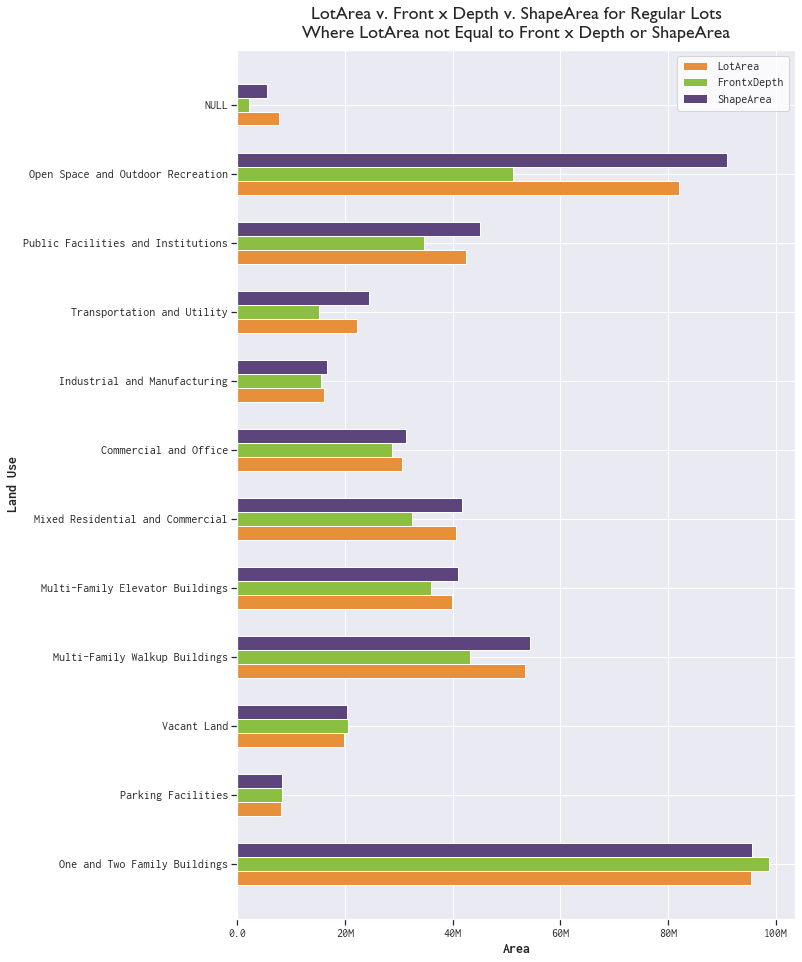

In [11]:
lotarea = landuse_reg_breakout['LotArea'].to_list()
frontxdepth = landuse_reg_breakout['FrontxDepth'].to_list()
shapearea = landuse_reg_breakout['ShapeArea'].to_list()
landuse = landuse_reg_breakout['def'].to_list()
df = pd.DataFrame(dict(graph=landuse,
                           n=lotarea, m=frontxdepth, o=shapearea)) 

ind = np.arange(len(df))
width = 0.2

fig, ax = plt.subplots(figsize=(10,16))
ax.barh(ind, df.n, width, color='#e88f39', label='LotArea')
ax.barh(ind + width, df.m, width, color='#8cbf41', label='FrontxDepth')
ax.barh(ind + width + width, df.o, width, color='#5c447c', label='ShapeArea')

ax.set(yticks=ind + width, yticklabels=df.graph, ylim=[2*width - 1, len(df)], xticklabels=df.n)
ax.xaxis.set_major_formatter(tick.FuncFormatter(x_fmt))
ax.set_xlabel("Area", fontweight="bold")
ax.set_ylabel("Land Use", fontweight="bold")
ax.tick_params(left=True, bottom=True)
plt.legend(loc='upper right', shadow='bool')
ax.legend()
legend = plt.legend()
frame = legend.get_frame()
frame.set_facecolor('white')
plt.title('LotArea v. Front x Depth v. ShapeArea for Regular Lots\nWhere LotArea not Equal to Front x Depth or ShapeArea', fontsize=18, fontname='Gill Sans', pad=12)

plt.show()

#### Part 2: Irregular Lots

How many irregular lots are there?

In [12]:
irregular_lot_count = pd.read_sql_query('''SELECT COUNT(*)
FROM dcp.mappluto_unclipped
WHERE "IrrLotCode" = 'Y';''', cnx)
irregular_lot_count

,count
0,134918


Of the irregular lots, how many have lots equal the shape area, and how many don't?

In [13]:
irregular_lotarea = pd.read_sql_query('''WITH irregular_lotarea AS (
SELECT "BBL",
CASE
    WHEN ROUND("LotArea") = ROUND("Shape_Area") THEN 'Y'
    ELSE 'N'
END AS lotarea_ind
FROM dcp.mappluto_unclipped
WHERE "IrrLotCode" = 'N'
)
SELECT lotarea_ind, COUNT(*)
FROM irregular_lotarea
GROUP BY lotarea_ind;''', cnx)
irregular_lotarea

,lotarea_ind,count
0,N,709591
1,Y,12451


Break out the areas by borough

In [14]:
boro_irreg_breakout = pd.read_sql_query('''SELECT "Borough",
SUM("LotArea") AS "LotArea",
SUM(ROUND("LotFront" * "LotDepth")) AS "FrontxDepth",
SUM(ROUND("Shape_Area")) AS "ShapeArea",
SUM(ROUND(("LotFront" * "LotDepth")) - "LotArea") AS Diff_LotArea_FxD,
SUM(ROUND("Shape_Area") - "LotArea") AS Diff_LotArea_SA
FROM dcp.mappluto_unclipped p
WHERE "IrrLotCode" = 'Y'
AND "LotArea" <> ROUND("LotFront" * "LotDepth")
AND "LotArea" <> ROUND("Shape_Area")
GROUP BY "Borough";''', cnx)
boro_irreg_breakout

,Borough,LotArea,FrontxDepth,ShapeArea,diff_lotarea_fxd,diff_lotarea_sa
0,BK,902300050,567721111.0,9.087167e+08,-334578939.0,6416609.0
1,BX,638776265,387147388.0,6.609232e+08,-251628877.0,22146916.0
2,MN,250736641,229239008.0,2.656974e+08,-21497633.0,14960785.0
3,QN,1303700513,917766218.0,1.442197e+09,-385934295.0,138496883.0
4,SI,857936848,714522450.0,9.182823e+08,-143414398.0,60345416.0


Break out the areas by landuse

In [15]:
landuse_irreg_breakout = pd.read_sql_query('''SELECT "LandUse",
COALESCE(def, 'NULL') AS def,
SUM("LotArea") AS "LotArea",
SUM(ROUND("Shape_Area")) AS "ShapeArea",
SUM(ROUND("Shape_Area") - "LotArea") AS Diff_LotArea_SA
FROM dcp.mappluto_unclipped p
LEFT JOIN dcp.landuse_definitions l
ON CAST(p."LandUse" AS INTEGER) = CAST(l.landuse AS INTEGER)
WHERE "IrrLotCode" = 'Y'
AND "LotArea" <> ROUND("Shape_Area")
GROUP BY "LandUse", def
ORDER BY diff_lotarea_sa DESC;''', cnx)
landuse_irreg_breakout

,LandUse,def,LotArea,ShapeArea,diff_lotarea_sa
0,9,Open Space and Outdoor Recreation,1499688769,1.732147e+09,232458584.0
1,7,Transportation and Utility,461528175,4.842619e+08,22733774.0
2,None,NULL,62790103,7.378118e+07,10991080.0
3,11,Vacant Land,424708937,4.342658e+08,9556858.0
4,1,One and Two Family Buildings,285863254,2.935369e+08,7673629.0
5,5,Commercial and Office,191970875,1.969682e+08,4997301.0
6,6,Industrial and Manufacturing,170343509,1.737027e+08,3359229.0
7,8,Public Facilities and Institutions,431337952,4.316680e+08,330075.0
8,10,Parking Facilities,52673892,5.224405e+07,-429843.0
9,3,Multi-Family Elevator Buildings,241603255,2.408118e+08,-791447.0


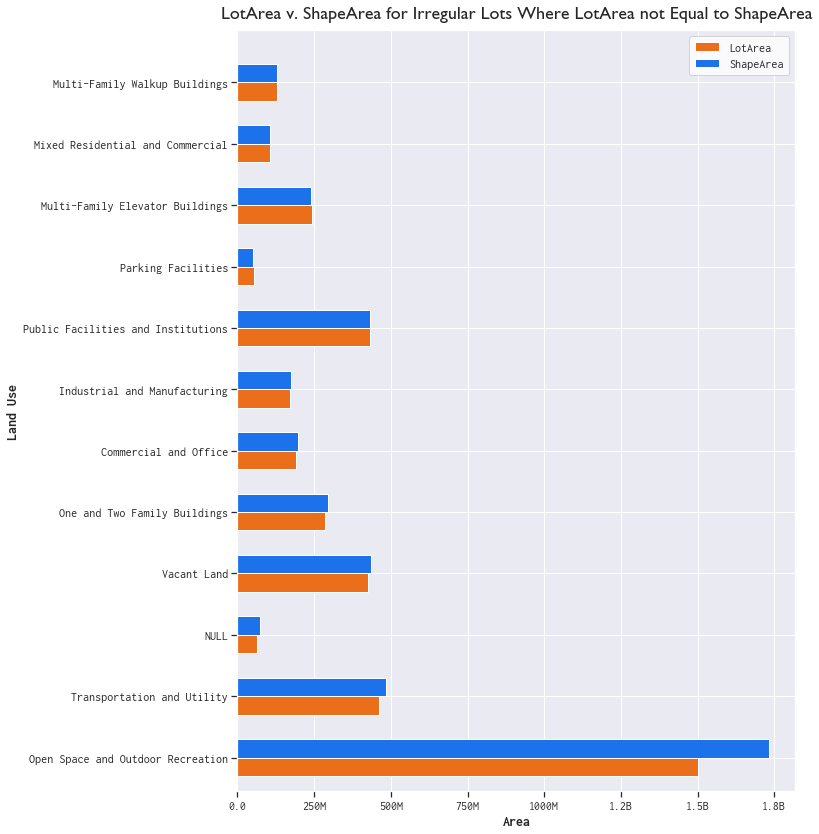

In [16]:
lotarea = landuse_irreg_breakout['LotArea'].to_list()
shapearea = landuse_irreg_breakout['ShapeArea'].to_list()
landuse = landuse_irreg_breakout['def'].to_list()
df = pd.DataFrame(dict(graph=landuse,
                           m=lotarea, n=shapearea)) 

ind = np.arange(len(df))
width = 0.3

fig, ax = plt.subplots(figsize=(10,14))
ax.barh(ind, df.m, width, color='#eb6e1b', label='LotArea')
ax.barh(ind + width, df.n, width, color='#1b72eb', label='ShapeArea')

ax.set(yticks=ind + (width / 2), yticklabels=df.graph, ylim=[2*width - 1, len(df)], xticklabels=df.n)
ax.xaxis.set_major_formatter(tick.FuncFormatter(x_fmt))
ax.set_xlabel("Area", fontweight="bold")
ax.set_ylabel("Land Use", fontweight="bold")
ax.tick_params(left=True, bottom=True)
plt.legend(loc='upper right', shadow='bool')
ax.legend()
legend = plt.legend()
frame = legend.get_frame()
frame.set_facecolor('white')
plt.title('LotArea v. ShapeArea for Irregular Lots Where LotArea not Equal to ShapeArea', fontsize=18, fontname='Gill Sans', pad=12)

plt.show()

#### Part 3: Impact of Replacing LotArea with Shape_Area for IrrLotCode Correction

How many records are we talking about?

In [17]:
wasregularcount = pd.read_sql('''SELECT COUNT(*) FROM dcp.irrlot_irregular
WHERE irrlotcode = 'N';''', cnx)
wasregularcount                        

,count
0,1096


Overall summary and difference

In [18]:
summary = pd.read_sql_query('''SELECT SUM(lotarea) AS lotarea_sum, 
SUM(COALESCE(ROUND(pluto_shape_area), lotarea)) AS replacement_sum, 
SUM(lotarea) - SUM(COALESCE(round(pluto_shape_area), lotarea)) AS difference
FROM dcp.mappluto_unclipped p
LEFT JOIN dcp.irrlot_irregular i
ON  i.irrlotcode = 'N'
AND i.bbl = p."BBL"''', cnx)
summary.to_csv('../output/summary.csv', index=False)
summary

,lotarea_sum,replacement_sum,difference
0,163349455,158619283.0,4730172.0


Breakout by borough

In [19]:
boro_breakout = pd.read_sql_query('''SELECT "Borough",
SUM(lotarea) AS lotarea_sum, 
SUM(COALESCE(ROUND(pluto_shape_area), lotarea)) AS replacement_sum, 
SUM(lotarea) - SUM(COALESCE(ROUND(pluto_shape_area), lotarea)) AS difference
FROM dcp.mappluto_unclipped p
LEFT JOIN dcp.irrlot_irregular i
ON i.bbl = p."BBL"
AND i.irrlotcode = 'N'
GROUP BY "Borough"
ORDER BY difference DESC;''', cnx)
boro_breakout.to_csv('../output/boro.csv', index=False)
boro_breakout

,Borough,lotarea_sum,replacement_sum,difference
0,SI,29763392,28182252.0,1581140.0
1,BX,22926391,21511683.0,1414708.0
2,BK,17798081,16432817.0,1365264.0
3,MN,13587755,13119958.0,467797.0
4,QN,79273836,79372573.0,-98737.0


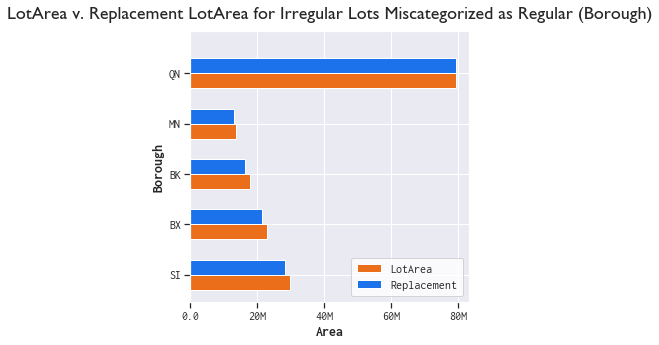

In [20]:
lotarea_sum = boro_breakout['lotarea_sum'].to_list()
shapearea_sum = boro_breakout['replacement_sum'].to_list()
boro = boro_breakout['Borough'].to_list()
df = pd.DataFrame(dict(graph=boro,
                           m=lotarea_sum, n=shapearea_sum)) 

ind = np.arange(len(df))
width = 0.3

fig, ax = plt.subplots(figsize=(5, 5))
ax.barh(ind, df.m, width, color='#eb6e1b', label='LotArea')
ax.barh(ind + width, df.n, width, color='#1b72eb', label='Replacement')

ax.set(yticks=ind + (width / 2), yticklabels=df.graph, ylim=[2*width - 1, len(df)], xticklabels=df.n)
ax.xaxis.set_major_formatter(tick.FuncFormatter(x_fmt))
ax.set_xlabel("Area", fontweight="bold")
ax.set_ylabel("Borough", fontweight="bold")
ax.tick_params(left=True, bottom=True)
plt.legend(loc='upper right', shadow='bool')
ax.legend()
legend = plt.legend()
frame = legend.get_frame()
frame.set_facecolor('white')
plt.title('LotArea v. Replacement LotArea for Irregular Lots Miscategorized as Regular (Borough)', fontsize=18, fontname='Gill Sans', pad=12)

plt.show()

Breakout by landuse

In [21]:
landuse_breakout = pd.read_sql_query('''
SELECT "LandUse",
COALESCE(def, 'NULL') AS def,
SUM(lotarea) AS lotarea_sum, 
SUM(COALESCE(ROUND(pluto_shape_area), lotarea)) AS replacement_sum, 
SUM(lotarea) - SUM(COALESCE(ROUND(pluto_shape_area), lotarea)) AS difference
FROM dcp.mappluto_unclipped p
LEFT JOIN dcp.irrlot_irregular i
ON i.bbl = p."BBL"
AND i.irrlotcode = 'N'
LEFT JOIN dcp.landuse_definitions d
ON CAST(d.landuse AS INTEGER) = CAST(p."LandUse" AS INTEGER)
GROUP BY "LandUse", def
ORDER BY difference desc;
''', cnx)
landuse_breakout.to_csv('../output/landuse.csv', index=False)
landuse_breakout

,LandUse,def,lotarea_sum,replacement_sum,difference
0,11,Vacant Land,18421440,4487831.0,13933609.0
1,7,Transportation and Utility,61649490,57810811.0,3838679.0
2,None,NULL,3948429,1916550.0,2031879.0
3,2,Multi-Family Walkup Buildings,10461073,9748114.0,712959.0
4,1,One and Two Family Buildings,3723184,3498858.0,224326.0
5,3,Multi-Family Elevator Buildings,7670067,7567230.0,102837.0
6,4,Mixed Residential and Commercial,4882329,4849565.0,32764.0
7,6,Industrial and Manufacturing,1775769,1752958.0,22811.0
8,10,Parking Facilities,1409762,1407242.0,2520.0
9,5,Commercial and Office,3351808,3392685.0,-40877.0


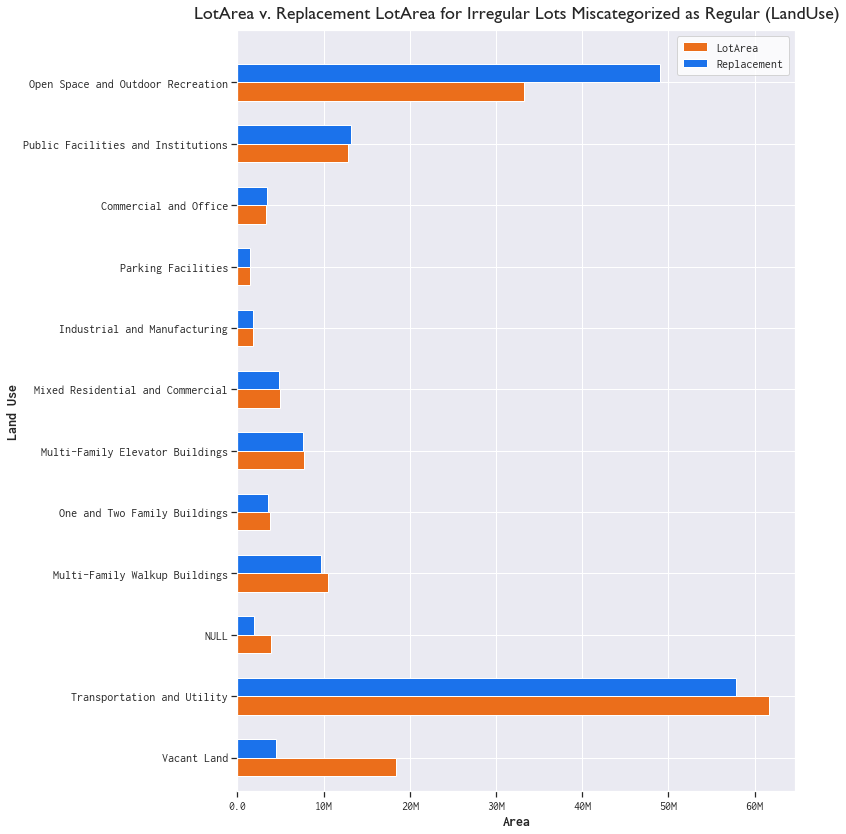

In [22]:
lotarea_sum = landuse_breakout['lotarea_sum'].to_list()
shapearea_sum = landuse_breakout['replacement_sum'].to_list()
landuse = landuse_breakout['def'].to_list()
df = pd.DataFrame(dict(graph=landuse,
                           m=lotarea_sum, n=shapearea_sum)) 

ind = np.arange(len(df))
width = 0.3

fig, ax = plt.subplots(figsize=(10,14))
ax.barh(ind, df.m, width, color='#eb6e1b', label='LotArea')
ax.barh(ind + width, df.n, width, color='#1b72eb', label='Replacement')

ax.set(yticks=ind + (width / 2), yticklabels=df.graph, ylim=[2*width - 1, len(df)], xticklabels=df.n)
ax.xaxis.set_major_formatter(tick.FuncFormatter(x_fmt))
ax.set_xlabel("Area", fontweight="bold")
ax.set_ylabel("Land Use", fontweight="bold")
ax.tick_params(left=True, bottom=True)
plt.legend(loc='upper right', shadow='bool')
ax.legend()
legend = plt.legend()
frame = legend.get_frame()
frame.set_facecolor('white')
plt.title('LotArea v. Replacement LotArea for Irregular Lots Miscategorized as Regular (LandUse)', fontsize=18, fontname='Gill Sans', pad=12)

plt.show()